# Deep Learning for NLP - Exercise 01
Building, Tuning and Evaluating a standard RNN Model

General hints:
* Have a look at the imports below when solving the tasks
* Use the given modules and all submodules of the imports, but don't import anything else!
    * For instance, you can use other functions under the `torch` or `nn` namespace, but don't import e.g. PyTorch Lightning, etc.
* It is recommended to install all packages from the provided environment file
* Feel free to test your code between sub-tasks of the exercise sheet, so that you can spot mistakes early (wrong shapes, impossible numbers, NaNs, ...)
* Just keep in mind that your final submission should be compliant to the provided initial format of this file

Submission guidelines:
* Make sure that the code runs on package versions from the the provided environment file
* Do not add or change any imports (also don't change the naming of imports, e.g. `torch.nn.functional as f`)
* Remove your personal, additional code testings and experiments throughout the notebook
* Do not change the class, function or naming structure as we will run tests on the given names
* Additionally export this notebook as a `.py` file, and submit **both** the executed `.ipynb` notebook with plots in it **and** the `.py` file
* **Deviation from the above guidelines will result in partial or full loss of points**

If you are using Google Colab or similar services, make sure to install all necessary packages so that the import cell below is working.

Usually, you would need to `!pip install`:
```
!pip install datasets==2.13.1
!pip install spacy==3.6.1
!pip install torch==2.0.1    # just to be sure we are all working with the same version
!pip install torchtext==0.15.2
!python -m spacy download en_core_web_sm
```

Make sure to comment out the lines before submitting!

In [1]:
# !pip install datasets==2.13.1
# !pip install spacy==3.6.1
# !pip install torch==2.0.1    # just to be sure we are all working with the same version
# !pip install torchtext==0.15.2
# !python -m spacy download en_core_web_sm


In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from datasets import load_dataset

In [3]:
def regularized_f1(train_f1, dev_f1, threshold=0.0015):
    """
    Returns development F1 if overfitting is below threshold, otherwise 0.
    """
    return dev_f1 if (train_f1 - dev_f1) < threshold else 0


def save_metrics(*args, path, fname):
    if not os.path.exists(path):
        os.makedirs(path)
    if not os.path.isfile(path + fname):
        with open(path + fname, "w", newline="\n") as f:
            f.write(
                ",".join(
                    [
                        "config",
                        "epoch",
                        "train_loss",
                        "train_acc",
                        "train_f1",
                        "val_loss",
                        "val_acc",
                        "val_f1",
                    ]
                )
            )
            f.write("\n")
    if args:
        with open(path + fname, "a", newline="\n") as f:
            f.write(",".join([str(arg) for arg in args]))
            f.write("\n")

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(1234)

In [4]:
VOCAB_SIZE = 20_000
BATCH_SIZE = 32
NUM_EPOCHS = 15
MAX_LEN = 256
LEARNING_RATE = 1e-4

## Task 1 - Download and prepare the dataset
- Load the train and test set of IMDB (it is included in the `datasets` module we imported above)
- Split the train set into train and validation set
    * Train set should consist of the middle 10% to 85% of data
    * Validation set should be the two remaining ends
    * You can achieve this slicing directly within the `load_dataset` function, check out the [Huggingface slicing API](https://huggingface.co/docs/datasets/v2.13.1/loading#slice-splits)
- Test set should stay unchanged

In [5]:
# load dataset in splits
dataset = load_dataset("imdb")
train_data = load_dataset("imdb", split="train[10%:85%]", )
dev_data = load_dataset("imdb", split="train[:10%]+train[85%:]")
test_data = load_dataset("imdb", split="test")

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 18750
})

* Define the tokenizer using `get_tokenizer` with spacy's `en_core_web_sm` module
    * You don't have to import spacy for that, but it is necessary to have spacy installed and the `en_core_web_sm` module downloaded
* Create the vocabulary using `build_vocab_from_iterator`
    * Think about which split(s) should be used to build the vocabulary
    * Include two special tokens: `'<UNK>'` at index `0`, `'<PAD>'` at index `1`
    * Limit the vocab size to `VOCAB_SIZE`, as defined in the beginning
    * Set the vocab's default returning index to `0` by making the `'<UNK>'` token default
    
Hint:
* This might be a good moment to add a personal test to check whether your vocab actually returns `0` for an unknown input token

In [7]:
# define tokenizer
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

# define vocabulary
vocab = build_vocab_from_iterator(
    map(tokenizer, train_data["text"]), specials=["<UNK>", "<PAD>"], max_tokens=VOCAB_SIZE
)
vocab.set_default_index(vocab["<UNK>"])

* Use the tokenizer and vocabulary to turn your three data splits into indices
* Limit the maximum tokenized sequence length to `MAX_LEN`

**Note**:
In practice, performing this step on its own during the preprocessing stage is usually not feasible due to the memory constraints associated with storing large datasets. Consequently, the tokenization and indexing steps are typically performed "on the fly" within the `DataLoader`, specifically in the `collate_batch` step.

In [8]:
train_idx = [vocab(tokenizer(ex['text']))[:MAX_LEN] for ex in train_data ]
dev_idx = [vocab(tokenizer(ex['text']))[:MAX_LEN] for ex in dev_data ]
test_idx = [vocab(tokenizer(ex['text']))[:MAX_LEN] for ex in test_data ]

* Define a torch dataset by inhereting from `Dataset`
* It should create the building block to return the tokenized indices and labels for a given index
* Instantiate it

In [9]:
class ImdbDataset(Dataset):
    def __init__(self, seq, lbl):
        self.seq = seq
        self.lbl = lbl

    def __getitem__(self, idx: int):

        return torch.LongTensor(self.seq[idx]), torch.tensor(self.lbl[idx])

    def __len__(self):
        return len(self.seq)

In [10]:
train_set = ImdbDataset(train_idx, train_data['label'])

* Having batches in which samples have a similar length, and thus less padding variations, improves training results
* A `GroupedSampler` allows us to create a sampler with which we can customize the data loading process
* It can then be implemented into the `DataLoader`, which automates loading data in multiple processes
* Write a sampler which allows us to group together samples of similar length into a batch
    * The `GroupedSampler` takes as input the tokenized sequences from `ImdbDataset`, as well as the batch size
    * First, in the `__init__` method, pair each sequence index with its tokenized sequence length
        * The result should be a list of tuples: `[(index, tokenized_sequence_length), ...]`
    * In the `__iter__` method, we now:
        * Shuffle the list
        * generate groups of size `BATCH_SIZE * 100`
        * Each group of size `BATCH_SIZE * 100` should be sorted in itself by the sequence length we calculated above
            * Sorting within each group is important because sorting based on the whole dataset would eliminate all training input variations
            * By shuffling in the `__iter__` method, we shuffle the set of indices in each new iteration (which equals an epoch), therefore, we keep input variation
        * The result should be a list of tuples sorted by ascending sequence length: `[(index, tokenized_sequence_length), ...]`
        * After each `BATCH_SIZE * 100` number of tuples, the sequence length of samples should drop and increase again
        * Example:
            ```
            Sample index 3199: (1234, 256)
            Sample index 3200: (567, 32)
            Sample index 3201: (890, 33)
            ```
        * Filter the created and sorted list to only consist of indices. Make sure to keep the sorting!
        * Return this list as an iterator
    * Complete the `__len__` method

In [11]:
class GroupedSampler(Sampler):
    def __init__(self, seqs, batch_size):
        self.seqs = [seq[0] for seq in seqs]
        self.batch_size = batch_size
        self.pair = [(i, len(seq)) for i, seq in enumerate(self.seqs)]

    def __iter__(self):
        random.shuffle(self.pair)
        batches = []
        for i in range(0, len(self.pair), self.batch_size * 100):
            batch = []
            for j in range(i, min(i + self.batch_size * 100, len(self.pair))):
                batch.append(self.pair[j])
            batch.sort(key=lambda x: x[1])
            batches.append(batch)
        # batches = [self.pair[i:i + self.batch_size * 100] for i in range(0, len(self.pair), self.batch_size * 100)]
        for batch in batches:
            batch.sort(key=lambda x: x[1])
        # print(batches)
        index_batches = [[index for index, _ in sorted_batch] for sorted_batch in batches]
        return iter(index_batches)

    def __len__(self):
        return len(self.pair)

* Now create the `GroupedSampler`, use it as input to create a `BatchSampler` (imported in the beginning)

* Define a collate function which takes in a `batch` of tokenized sequences and labels created by the `BatchSampler`
    * Make sure to understand the structure of an input `batch`. Test around a bit to see what exactly they return.
* The collate function then:
    * pads these indices to the same length
        * use `padding_value=1`, `0` should be reserved for `UNK` token
    * turns the labels into tensors
    * finally, it creates a tensor which stores the length of all tokenized sentences **before** padding
    * the function should return 3 batched tensors: sequences, labels, lengths

In [12]:
# define collate function
def collate_batch(batch):
    sequences, labels = zip(*batch)

    # Pad the sequences to the same length and turn them into a tensor
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=1)

    # Convert the labels into a tensor
    tensor_labels = torch.tensor(labels, dtype=torch.float32)

    # Get the lengths of all tokenized sentences before padding
    lengths = torch.tensor([len(seq) for seq in sequences])

    return padded_sequences, tensor_labels, lengths

* Now create the final `DataLoader` for the train set
    * For your training, set the number of workers to your liking/cpu cores setup
    * When submitting this exercise, please set `num_workers=2` at maximum
* Repeat the `DataLoader` creation process for the validation and test set
    * It is not necessary to introduce randomness into the validation and test set
    * Create an `ImdbDataset` and `DataLoader` instance
    * leave `shuffle` off and don't include any Samplers
    * still include the correct batch size and collate function

In [13]:
# create dataloaders
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    num_workers=2,
    shuffle=False,
)

dev_set = ImdbDataset(dev_idx, dev_data['label'])
test_set = ImdbDataset(test_idx, test_data['label'])

dev_loader = DataLoader(
    dev_set,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    num_workers=2,
    shuffle=False,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    num_workers=2,
    shuffle=False,
)

## Task 2 - Build Your Model
The model should consist of:
- an **embedding layer**, which takes `vocab_size` and `embedding_dim` as parameters
- a **dropout layer**, which takes `dropout` as a parameter
- an **LSTM layer**, which takes `embedding_dim` and `rnn_size` as parameters, and is bidirectional
- a **linear layer**, which takes the dimension of rnn output as input dimension and returns an output of `hidden_size` dimensions
- a **linear layer**, which first takes the previous layers output as input and returns one prediction per class of the dataset
- the output of the BiLSTM has hidden representation tensors for each index of each sequence. However, for the task of sequence classification, we just need one hidden representation tensor per sequence. Use `torch.mean()` as a pooling function for dimensionality reduction.
- use **dropout** on the embeddings and appropriate linear layer
- use **ReLU** as the activation function on the appropriate linear layer

_Hints:_
  - keep the position of the batch dimension equal across all layers
  - _use `pack_padded_sequence`_ and `pad_packed_sequence` at the appropriate steps. For more information, check out [this answer on stackoverflow](https://stackoverflow.com/a/56211056)
  - remember to include the `padding_idx=1` at relevant positions
  - as this is a binary classification task, it is possible to have 1 or 2 output neurons. Use your preference, but adjust the loss function towards your choice

In [14]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_size, hidden_size, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_dim, rnn_size, bidirectional=True, batch_first=True)
        self.pooling = nn.Linear(rnn_size * 2, hidden_size)
        self.fc1 = nn.Linear(hidden_size, 1)

    def forward(self, seq, lengths):
        embedded = self.dropout(self.embedding(seq))

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        hidden = self.dropout(torch.mean(output, dim=1))
        pooling_output = F.relu(self.pooling(hidden))
        output = self.fc1(pooling_output)

        return output.flatten()

## Task 3 - Inner train loop
* Create a global `device` variable which checks whether a GPU is available or not, and sets the device to either GPU or CPU.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

* Write the inner train/test loop by completing the function `process`.
    * It takes the model, a dataloader, criterion and optionally the optimizer
    * The function iterates once through the dataloader, i.e. one epoch
    * Include the `tqdm` functionality for the loop through the dataloader by placing the loader inside `tqdm()`
        * Print its output to `file=sys.stdout`, and use `'batches'` as unit
        * You can also add a `desc='...'` to get a marking whether we currently train or evaluate
    * The function also moves the sequences and labels to `device`
    * The `lengths` need to stay on CPU!
    * If the optimizer is given, training with backpropagation is performed, then the below defined metrics are returned
    * If the optimizer is missing, evaluation is performed and the below described metrics are calculated
    * Values to be calculated:
        * Loss, Accuracy, both as averages of the total number of samples per epoch
        * F1 score between all predictions and labels of the epoch

In [16]:
def process(model, loader, criterion, optim=None, device='cuda', train=False):

    if train:
        model.train()
        desc = 'Training'
    else:
        model.eval()
        desc = 'Evaluating'

    total_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad() if optim is None else torch.enable_grad():
        for batch in tqdm(loader, file=sys.stdout, unit='batches', desc=desc):
            # Move sequences and labels to the specified device
            sequences, labels, lengths = batch
            sequences, labels = sequences.to(device), labels.to(device)

            # Forward pass
            outputs = model(sequences, lengths)
            preds = torch.round(torch.sigmoid(outputs))
            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            if optim is not None:
                # Backpropagation and optimization during training
                optim.zero_grad()
                loss.backward()
                optim.step()


            # Collect predictions and labels for F1 score and accuracy calculation
            all_predictions.append(preds)
            all_labels.append(labels)

    # Calculate average loss, F1 score, and accuracy
    avg_loss = total_loss / len(loader)
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    f1 = f1_score(all_labels.cpu(), all_predictions.detach().cpu(), average='weighted')
    correct = sum(1 for lbl, pred in zip(all_labels.cpu(), all_predictions.detach().cpu()) if lbl == pred)
    total = len(all_labels.cpu())
    accuracy = correct / total

    return avg_loss, accuracy, f1

# Task 4 - Training and Hyperparameter Optimization
In the following, we provide 3 configurations for the above created BiLSTM. Try to understand how they differ from each other.

In [17]:
configs = {
    "config1": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 10,
        "hidden_size": 10,
        "rnn_size": 10,
        "dropout": 0.5
    },
    "config2": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 64,
        "hidden_size": 32,
        "rnn_size": 256,
        "dropout": 0.5
    },
    "config3": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 300,
        "hidden_size": 256,
        "rnn_size": 256,
        "dropout": 0.5
    }

}

* Choose the correct criterion to train and evaluate your created model

In [18]:
criterion = nn.BCEWithLogitsLoss()

Use the given functions `regularized_f1` and `save_metrics` from the start of the notebook to implement the hyperparameter search and training runs.

Specifically:
* Iterate through each configuration
* Create and re-create the model for each new configuration run
    * Move the model to the `device`
* Create and re-create the optimizer with each new configuration model's paramaters
    * Use Adam as the optimizer
    * Use the learning rate defined at the beginning of notebook
* Train each configuration for `NUM_EPOCHS` epochs
* Change the model into train and evaluation mode at appropriate times
* Stop gradient calculation for evaluation runs
* Save metrics after each train and evaluation runs.
    * Have a look at the function to see what the expected inputs are
    * In the `.csv` file, only numbers should be entered
    * For instance, the inputs for the columns `config` and `epoch` should be e.g. `1`, _not_ `config1` or `epoch1`
* Optional: Print training progress for your own information

In order to check whether our model generalizes or just 'remembers', we need to compare the model's performance on the train set to the performance on the validation set. As we are only interested in non-overfitting performances, we only want to save model checkpoints when the model actually generalizes, i.e. has a higher F1 score on the validation set than on the train set.
* Calculate the regularized f1 score using the given function
* Keep track of multiple values during training:
    * Save the overall (i.e. across all configs *and* epochs) highest validation F1 score
        * Save your best model parameters
        * Overwrite your model parameters every time your model fulfills both the `regularized_f1` criteria and is better than the previous overall highest F1 score
        * In the end, the last saved `best_model.pt` parameters are automatically the best
        * Hint: Keep track (e.g. by printing or in a variable), which config produced the best model, so you can directly load that config for the test set run.
    * Track the highest F1 score inside a configuration but across epochs
        * Implement early-stopping for a configuration run if 3 consecutive epochs are below the highest F1 score for the current configuration

In [19]:
path = './'
logging_file = 'results.csv'

for config_n, (config_name, config) in enumerate(configs.items(), start=1):
    # Create and re-create the model for each new configuration run
    model = BiLSTM(**config)
    model.to(device)

    # Create and re-create the optimizer with each new configuration model's parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Initialize variables for early stopping
    best_f1 = -1
    best_overall_f1 = -1
    consecutive_epochs_below_best = 0
    best_model_config = config_n
    for epoch in range(NUM_EPOCHS):
        # Training
        model.train()
        train_loss, train_acc, train_f1 = process(model, train_loader, criterion, optimizer, device=device, train=True)

        # Evaluation
        model.eval()
        val_loss, val_acc, val_f1 = process(model, dev_loader, criterion, device=device, train=False)

        # Save metrics
        save_metrics(config_n, epoch, train_loss, train_acc, train_f1, val_loss, val_acc, val_f1, path=path, fname=logging_file)

        # Calculate regularized F1
        reg_f1 = regularized_f1(train_f1, val_f1)

        # Check if this model is the best overall
        if reg_f1 > best_overall_f1:
            best_overall_f1 = reg_f1
            best_model_config = config_name
            # Save the model checkpoint
            torch.save(model.state_dict(), 'best_model.pt')

        # Check if early stopping should be applied
        if val_f1 > best_f1:
            best_f1 = val_f1
            consecutive_epochs_below_best = 0
        else:
            consecutive_epochs_below_best += 1

        if consecutive_epochs_below_best >= 3:
            print(f"Early stopping for config {config_n} at epoch {epoch}")
            break

# After all configurations are done, load the best model
best_model = BiLSTM(**configs[best_model_config])
best_model.load_state_dict(torch.load('best_model.pt'))
best_model.to(device)

Evaluating: 100%|██████████| 196/196 [00:02<00:00, 91.31batches/s] 
Early stopping for config 1 at epoch 5
Evaluating: 100%|██████████| 196/196 [00:02<00:00, 73.10batches/s]
Early stopping for config 2 at epoch 3
Evaluating: 100%|██████████| 196/196 [00:02<00:00, 71.95batches/s]
Early stopping for config 3 at epoch 3


BiLSTM(
  (embedding): Embedding(20000, 300, padding_idx=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (pooling): Linear(in_features=512, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

* Load in the created `results.csv` file
* Create 6 plots: 3 rows with each 2 sub-plots
* Each row of plots should correspond to a configuration
* Each left plot shows the loss progression per epoch
    * Include both train and evaluation progress in the same plot, but plot the evaluation lines dashed
    * Plot losses in blue
* Each right plot shows both the accuracy and F1 progression per epoch
    * Include both train and evaluation progess in the same plot, but plot the evaluation lines dashed
    * Plot accuracy in orange, and plot F1 in green
* Have a look at the example plot file included with this exercise. It constitutes one row of the plot.
* After plotting, briefly describe what problems and successes you see with each configuration

In [20]:
df = pd.read_csv('results.csv')

In [21]:
df

,config,epoch,train_loss,train_acc,train_f1,val_loss,val_acc,val_f1
0,1,0,0.698700,0.428000,0.427423,0.688283,0.60000,0.450000
1,1,1,0.697063,0.450240,0.432652,0.690066,0.60000,0.450000
2,1,2,0.695837,0.471893,0.428431,0.691575,0.55824,0.518131
3,1,3,0.695138,0.485973,0.418777,0.692956,0.50096,0.506001
4,1,4,0.694861,0.499520,0.407317,0.694186,0.47344,0.466880
5,1,5,0.694280,0.509653,0.398212,0.695156,0.44944,0.400544
6,2,0,0.435418,0.886347,0.885220,2.883664,0.60000,0.450000
7,2,1,0.830694,0.437387,0.437790,0.684612,0.60000,0.450000
8,2,2,0.693457,0.448000,0.442883,0.676950,0.60000,0.450000
9,2,3,0.694455,0.490613,0.472311,0.678295,0.60000,0.450000


In [22]:
for i, config in enumerate(configs):
    config_data = df[df['config'] == config]
    print(config_data)

Empty DataFrame
Columns: [config, epoch, train_loss, train_acc, train_f1, val_loss, val_acc, val_f1]
Index: []
Empty DataFrame
Columns: [config, epoch, train_loss, train_acc, train_f1, val_loss, val_acc, val_f1]
Index: []
Empty DataFrame
Columns: [config, epoch, train_loss, train_acc, train_f1, val_loss, val_acc, val_f1]
Index: []


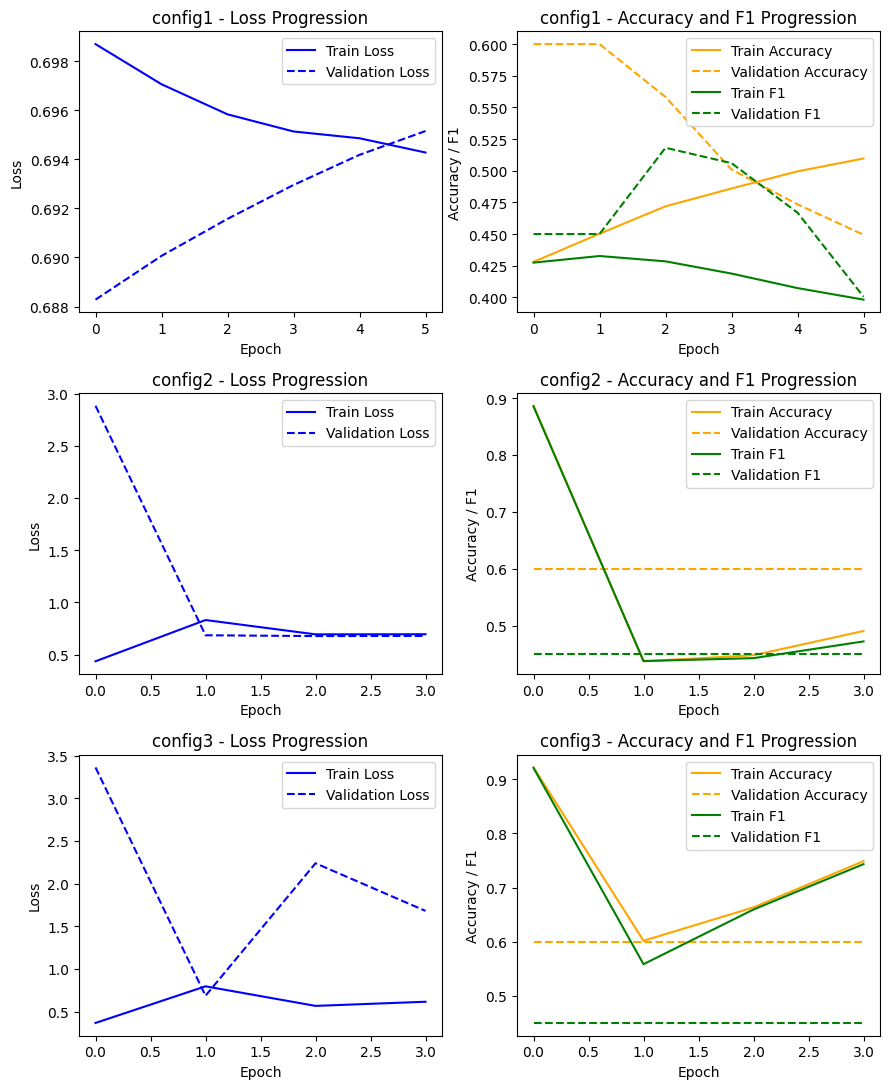

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(9, 11))


for i, config in enumerate(configs):
    config_data = df[df['config'] == i + 1]

    # Left plot: Loss progression
    ax[i, 0].plot(config_data['epoch'], config_data['train_loss'], label='Train Loss', color='blue')
    ax[i, 0].plot(config_data['epoch'], config_data['val_loss'], label='Validation Loss', color='blue', linestyle='dashed')
    ax[i, 0].set_title(f'{config} - Loss Progression')
    ax[i, 0].set_xlabel('Epoch')
    ax[i, 0].set_ylabel('Loss')
    ax[i, 0].legend()

    # Right plot: Accuracy and F1 progression
    ax[i, 1].plot(config_data['epoch'], config_data['train_acc'], label='Train Accuracy', color='orange')
    ax[i, 1].plot(config_data['epoch'], config_data['val_acc'], label='Validation Accuracy', color='orange', linestyle='dashed')
    ax[i, 1].plot(config_data['epoch'], config_data['train_f1'], label='Train F1', color='green')
    ax[i, 1].plot(config_data['epoch'], config_data['val_f1'], label='Validation F1', color='green', linestyle='dashed')
    ax[i, 1].set_title(f'{config} - Accuracy and F1 Progression')
    ax[i, 1].set_xlabel('Epoch')
    ax[i, 1].set_ylabel('Accuracy / F1')
    ax[i, 1].legend()


plt.tight_layout()
plt.show()

___

Student answer here:
___

* As the final step, instantiate a model with the config of the best run
* Load the `state_dict`
* Evaluate it on the test set
    * Don't forget to actviate evaluation mode and deactivate gradient calculation
* Comment on the performance
    * Did it generalize well? Why? Why not?
    * What could be done to improve the performance even further?
        * Consider also the hyperparameters from the third cell and discuss potential tradeoffs.

In [24]:
model = BiLSTM(**configs[best_model_config])
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()
with torch.no_grad():
    test_loss, test_acc, test_f1 = process(model, test_loader, criterion, device=device, train=False)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test F1: {test_f1:.4f}")

Evaluating: 100%|██████████| 782/782 [00:11<00:00, 68.24batches/s]
Test Loss: 4.2707 | Test Accuracy: 0.5000 | Test F1: 0.3333


___

Student answer here:
___

For this model, the performance in general is not very good regardless of the configuration. one potential issue can be the dataset itself which does not have enough samples for each class or the parts of the data that were choosen were not varied enough to make the model learn

A potential solution is randomizing the dataset slices and cross-validating with folds, which is a very common technique for classification problems.

The model seems very unstable in either configuration and this has to be mitigates by randomizing the dataset and trying with other parts of the data.